# Retrospective Changes in COVID-19 Daily Death Counts in England
**Investigating how death counts for past dates of death change with each updated release**

![img](meteors.png)

*Each dot represents the count for one date of death as reported in a single release. Each vertical line of dots represents all counts for one date of death as reported in consecutive releases. Points form coloured strata to preserve a sense of how the reported counts increase over time.*<br/>
Find the code for this plot [below](#Meteors)

## Key points
- Deaths from COVID-19 are initially underestimated
- Through additional releases, the counts approach the final figure over the course of several days
- The discrepancy was greatest during the latest pandemic 'wave'
- For parts of the dataset where the data is complete (Aug-Nov):
    - The largest difference between initially reported count and final count was 328 deaths for 15 November
    - On average, the difference between smallest and largest reported counts was 112 deaths
    - On average, it takes 12 days for counts to reach 90-95% of the final figure
    - On average, counts approach 80-85% of the final figure after 5 days

## Navigate

- [Downloading the data](#Downloading-the-releases-from-PHE)
- [Preparing the data](#Load-data-into-pandas)
- [Exploring the data](#Exploring-the-data-with-pandas-and-matplotlib)
- [Charting the discrepancy](#Charting-the-discrepancy)
- [Approximating time to complete reporting](#How-quickly-do-the-counts-approach-their-'true'-value?)
- [Accuracy after 'x' days](#Accuracy-of-count-'x'-days-after-first-report)
- [Other visualisations](#Alternative-visualisations)
    - [Meteors](#Meteors)
    - [Dropped straws](#Dropped-straws)
- [Ideas for further work](#Ideas-for-further-work)

The data in this document comprise the number of NEW deaths from COVID-19 on EACH day in the period 03-01-2020 to 28-Nov-2020. The data are collected from multiple authorities and reported to Public Health England. PHE makes the data available through daily releases. Each release includes new deaths from the previous day and updated figures for all days prior to that.

Reports of deaths often do not reach PHE on the date they actually occurred. In many cases, it can take a number of days post mortem for a death to be included in a PHE release. This leads to an initial under-reporting of COVID-19 mortality that gradually approaches its true figure over the course of several additional releases.

I wanted to characterise how much the reported number of deaths on a given date changed between initial release and the latest release for that date. I was also interested in exploring how many releases it takes to arrive at the final figure (or a number approaching the final figure, e.g. 50%, 75%, or 95% of the total). In short, I wanted to quantify how the discrepancy between reported and actual deaths changed with respect to time since initial release.

## Downloading the releases from PHE

In [1]:
import requests

First I needed to retrieve the data I'm interested in. I was able to do this through [PHE's public API](https://coronavirus.data.gov.uk/details/developers-guide). The API allows you to request up to 5 metrics and optionally specify a subregion of the UK. There is also a parameter 'release' that allows you to specify a historic version of the data, i.e. the data as it was published on a specific day in the past. These 'archive' versions of the data are accompanied by the following caveats:

![img](caveats.png)

I only wanted the data for England, and I was only interested in the new deaths within 28 days of a positive test. Since I could only specify one release date per request, a single API query looked like this:

In [2]:
res = requests.get('https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newDeaths28DaysByDeathDate&format=csv&release=2020-11-26')

print(res.text)

date,areaType,areaCode,areaName,newDeaths28DaysByDeathDate
"2020-11-26",nation,E92000001,England,
"2020-11-25",nation,E92000001,England,111
"2020-11-24",nation,E92000001,England,287
"2020-11-23",nation,E92000001,England,331
"2020-11-22",nation,E92000001,England,363
"2020-11-21",nation,E92000001,England,317
"2020-11-20",nation,E92000001,England,360
"2020-11-19",nation,E92000001,England,362
"2020-11-18",nation,E92000001,England,399
"2020-11-17",nation,E92000001,England,345
"2020-11-16",nation,E92000001,England,351
"2020-11-15",nation,E92000001,England,358
"2020-11-14",nation,E92000001,England,351
"2020-11-13",nation,E92000001,England,349
"2020-11-12",nation,E92000001,England,344
"2020-11-11",nation,E92000001,England,312
"2020-11-10",nation,E92000001,England,314
"2020-11-09",nation,E92000001,England,402
"2020-11-08",nation,E92000001,England,338
"2020-11-07",nation,E92000001,England,324
"2020-11-06",nation,E92000001,England,332
"2020-11-05",nation,E92000001,England,302
"2020-11-04",nation,

To get death data from all releases, I wrote the following snippets to submit a request like the one above for each release date, using string formatting and a for loop.

In [3]:
# First of all, I generated a list of dates relating to the release dates I wanted (23 Aug to 28 Nov), 
# correctly formatted for the API query

# release_dates = []
# days_31 = 1
# for m in range(8,13): # August to December
#     if days_31:
#         ds = ['2020-'+f'{m:02d}'+'-'+f'{d:02d}' for d in range(1,32)] # List comprehension and f-string formatting
#         release_dates.extend(ds)
#         days_31 = 0
#     else:
#         ds = ['2020-'+f'{m:02d}'+'-'+f'{d:02d}' for d in range(1,31)]
#         release_dates.extend(ds)
#         days_31 = 1

# the fair use policy allowed a max of 100 requests per hour, so I limited my requests
# to the last 100 days, which turned out to be more than enough:

# release_dates = release_dates[-131:-31]
# len(release_dates)

In [4]:
# import time

In [6]:
# url_start = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newDeaths28DaysByDeathDate&format=csv&release='

# if 'DATA' not in os.listdir():
#     os.mkdir('DATA')

# for rd in release_dates:
#     url = url_start + rd #<-- 'release' is the last parameter in the query, so this concat will generate a valid query for each item in release_dates
#     filename = './DATA/phe_overview_'+rd+'.csv'
#     res = requests.get(url)
#     response_code = str(res.status_code)


##    some retry attempts and response-code logging incase of bad requests…

#     count = 0
#     while res.status_code in [429, 500] and count < 2:
#         count += 1
#         time.sleep(5)
#         res = requests.get(url)
#         with open('log.txt', 'a') as f:
#             f.write(rd+'\t'+str(count)+'\t'+response_code+'\n')
        
#     while res.status_code in [429, 500] and count < 4:
#         time.sleep(155)
#         count += 1
#         with open('log.txt', 'a') as f:
#             f.write(rd+'\t'+str(count)+'\t'+response_code+'\n')

##    save response text as a .csv file…

#     with open(filename, 'w') as f:
#         f.write(res.text)
    
#     time.sleep(11) #<-- Fair use policy allows a maximum of 10 requests every 100 seconds

After running, the following files had been created. I cast the filenames from an os.listdir() to a list.

In [7]:
import os

releases = [f for f in os.listdir('./DATA') if f.startswith('phe_overview')]

releases.sort()

releases

['phe_overview_2020-08-23.csv',
 'phe_overview_2020-08-24.csv',
 'phe_overview_2020-08-25.csv',
 'phe_overview_2020-08-26.csv',
 'phe_overview_2020-08-27.csv',
 'phe_overview_2020-08-28.csv',
 'phe_overview_2020-08-29.csv',
 'phe_overview_2020-08-30.csv',
 'phe_overview_2020-08-31.csv',
 'phe_overview_2020-09-01.csv',
 'phe_overview_2020-09-02.csv',
 'phe_overview_2020-09-03.csv',
 'phe_overview_2020-09-04.csv',
 'phe_overview_2020-09-05.csv',
 'phe_overview_2020-09-06.csv',
 'phe_overview_2020-09-07.csv',
 'phe_overview_2020-09-08.csv',
 'phe_overview_2020-09-09.csv',
 'phe_overview_2020-09-10.csv',
 'phe_overview_2020-09-11.csv',
 'phe_overview_2020-09-12.csv',
 'phe_overview_2020-09-13.csv',
 'phe_overview_2020-09-14.csv',
 'phe_overview_2020-09-15.csv',
 'phe_overview_2020-09-16.csv',
 'phe_overview_2020-09-17.csv',
 'phe_overview_2020-09-18.csv',
 'phe_overview_2020-09-19.csv',
 'phe_overview_2020-09-20.csv',
 'phe_overview_2020-09-21.csv',
 'phe_overview_2020-09-22.csv',
 'phe_ov

In [8]:
# Quick check on one of the files for formatting and content:

with open('./DATA/phe_overview_2020-11-30.csv', 'r') as f:
    print(f.read())

date,areaType,areaCode,areaName,newDeaths28DaysByDeathDate
"2020-11-30",nation,E92000001,England,
"2020-11-29",nation,E92000001,England,50
"2020-11-28",nation,E92000001,England,158
"2020-11-27",nation,E92000001,England,232
"2020-11-26",nation,E92000001,England,290
"2020-11-25",nation,E92000001,England,352
"2020-11-24",nation,E92000001,England,364
"2020-11-23",nation,E92000001,England,357
"2020-11-22",nation,E92000001,England,383
"2020-11-21",nation,E92000001,England,339
"2020-11-20",nation,E92000001,England,375
"2020-11-19",nation,E92000001,England,382
"2020-11-18",nation,E92000001,England,425
"2020-11-17",nation,E92000001,England,356
"2020-11-16",nation,E92000001,England,357
"2020-11-15",nation,E92000001,England,374
"2020-11-14",nation,E92000001,England,355
"2020-11-13",nation,E92000001,England,355
"2020-11-12",nation,E92000001,England,347
"2020-11-11",nation,E92000001,England,312
"2020-11-10",nation,E92000001,England,318
"2020-11-09",nation,E92000001,England,402
"2020-11-08",nation,E

The request for 2020-10-07 persistently responded with a 500 error. Consequently, the corresponding .csv file is empty.

In [9]:
with open('./DATA/phe_overview_2020-10-07.csv', 'r') as f:
    print(len(f.read()))

0


In order to work with the dataset in pandas and matplotlib, I either need to drop this release from the dataset or fill it in somehow. Since it's only the data from a single release, I'm more comfortable dropping it entirely than attempting to infer values from the other releases. I'm trying to analyse how releases differ with respect to each other, so to invent data for one such release doesn't seem like the right thing to do. 

In [10]:
print(len(releases))

releases.remove('phe_overview_2020-10-07.csv')

print(len(releases))

100
99


## Load data into pandas

In [11]:
import pandas as pd

First, I'll check out how a single .csv looks when loaded into a dataframe

In [13]:
df0 = pd.read_csv('./DATA/'+releases[0], parse_dates=[0])

df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        234 non-null    datetime64[ns]
 1   areaType                    234 non-null    object        
 2   areaCode                    234 non-null    object        
 3   areaName                    234 non-null    object        
 4   newDeaths28DaysByDeathDate  171 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 9.3+ KB


So far so good. Since there are no fractional deaths, I'll convert to int after I load the full dataset.

As a quick sanity check, I make sure that each day of the week is equally represented across the dates of death.

In [ ]:
df0['date'].apply(lambda d:d.dayofweek).value_counts()

At this point, I'm happy to load the rest of the data set. The following loop uses an outer merge, since each release introduces a new date for which previous releases have no data. I'm not interested in areaType, areaCode, or areaName: they are the same for every entry in every release and not relevant to the analysis I want to perform. I only read in the date of death (column 0) and the death count (column 4). The result is a union of reported death counts per date of death from all valid releases.

In [14]:
df = pd.DataFrame(columns=['DoD'])

for r in releases:
    df_r = pd.read_csv('./DATA/'+r, parse_dates=[0], usecols=[0,4], dtype={'newDeaths28DaysByDeathDate':'Int64'})
    release_date = df_r.iloc[0,0]
    df_r = df_r.rename(columns={'date':'DoD','newDeaths28DaysByDeathDate':release_date})
    df = pd.merge(df, df_r, how='outer', on='DoD')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 333
Data columns (total 100 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DoD                  334 non-null    datetime64[ns]
 1   2020-08-23 00:00:00  171 non-null    Int64         
 2   2020-08-24 00:00:00  172 non-null    Int64         
 3   2020-08-25 00:00:00  173 non-null    Int64         
 4   2020-08-26 00:00:00  174 non-null    Int64         
 5   2020-08-27 00:00:00  175 non-null    Int64         
 6   2020-08-28 00:00:00  176 non-null    Int64         
 7   2020-08-29 00:00:00  176 non-null    Int64         
 8   2020-08-30 00:00:00  176 non-null    Int64         
 9   2020-08-31 00:00:00  179 non-null    Int64         
 10  2020-09-01 00:00:00  180 non-null    Int64         
 11  2020-09-02 00:00:00  181 non-null    Int64         
 12  2020-09-03 00:00:00  182 non-null    Int64         
 13  2020-09-04 00:00:00  183 non-null 

The pandas documentation recommends arranging variables by column and observations by row. I considered each release to count as a new observation, so I rearranged the dataframe to have a column for each date of death, so each row stores the death count on each date of death, as reported on that particular release date. This was also a convenient format for producing graphs of reported deaths plotted against release date.

_In hindsight, I might have kept the columns as the releases and rows as date of death. This would make it easier to add columns of more descriptive data to the end of the df. It's not difficult to then use filtering and transforms to make the data fit for graphing._

In [16]:
df = df.set_index('DoD').sort_index().dropna(how='any', thresh=2, axis=0).transpose().sort_index()

df.index.name = 'Release Date'

In [17]:
df = df.set_index(pd.DatetimeIndex(df.index))

In [18]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2020-08-23 to 2020-11-30
Columns: 272 entries, 2020-03-02 to 2020-11-28
dtypes: Int64(272)
memory usage: 237.4 KB
None


,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,...,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28
Release Date,,,,,,,,,,,,,,,,,,,,,
2020-08-23,1,2,<NA>,3,<NA>,<NA>,3,5,3,8,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-08-24,1,2,<NA>,3,<NA>,<NA>,3,5,3,8,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-08-25,1,2,<NA>,3,<NA>,<NA>,3,5,3,8,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-08-26,1,2,<NA>,3,<NA>,<NA>,3,5,3,8,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-08-27,1,2,<NA>,3,<NA>,<NA>,3,5,3,8,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Descriptive statistics for a random sample of dates of death. The 'count' column tells us how many releases include a figure for a given date of death.

In [19]:
df.describe().round(0).astype(int).transpose().sample(30).sort_index()

,count,mean,std,min,25%,50%,75%,max
2020-03-15,99,32,0,32,32,32,32,32
2020-04-03,99,744,1,743,743,744,744,744
2020-04-15,99,783,0,782,783,783,783,784
2020-04-16,99,751,0,750,750,751,751,751
2020-05-01,99,478,0,476,477,478,478,478
2020-05-09,99,330,1,325,330,330,330,331
2020-05-11,99,260,0,259,260,260,260,260
2020-05-12,99,274,1,271,274,274,274,275
2020-05-14,99,278,1,271,278,278,278,278
2020-05-31,99,112,0,112,112,112,112,112


Now I have a dataframe containing the number of deaths occurring on each date from 2 March to 28 November 2020, as reported in each PHE release from 23 August to 30 November 2020.

## Exploring the data with pandas and matplotlib

In [20]:
import matplotlib.pyplot as plt

For a sanity check, I plotted the most up to date data points for each date of death (.max() for each column) against time. This should produce a graph that is now somewhat familiar, showing the peak of the first wave in April followed by several months of decline and no-growth, followed by the second wave starting in October.

You can see the effect of the underreported statistics in the precipitous drop at the very end of the graph.

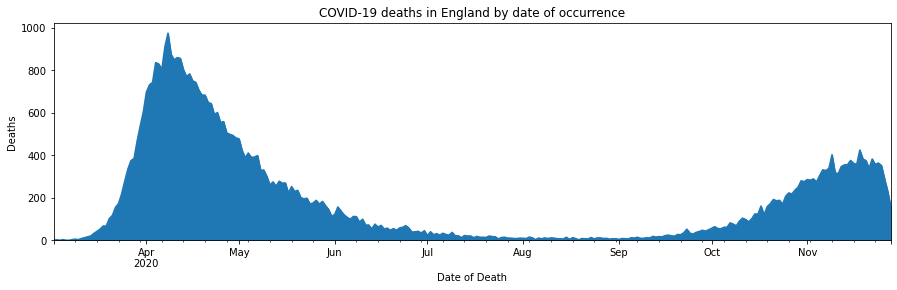

In [21]:
df.max().plot(figsize=(15,4), 
              kind='area', 
              title='COVID-19 deaths in England by date of occurrence', 
              ylabel='Deaths', 
              xlabel='Date of Death')

plt.show()

To get an idea of how the count changed over time for a date of death with a large discrepancy, I plotted the eight available data points for 2020-11-22.

The release on 23 November 2020 reported around 70 deaths had occurred on 22 November. Over the next seven days, that figure was revised upwards to over 350; more than five times initial figure. The curve has a logarithmic shape, reaching 350 within the first 4 releases.

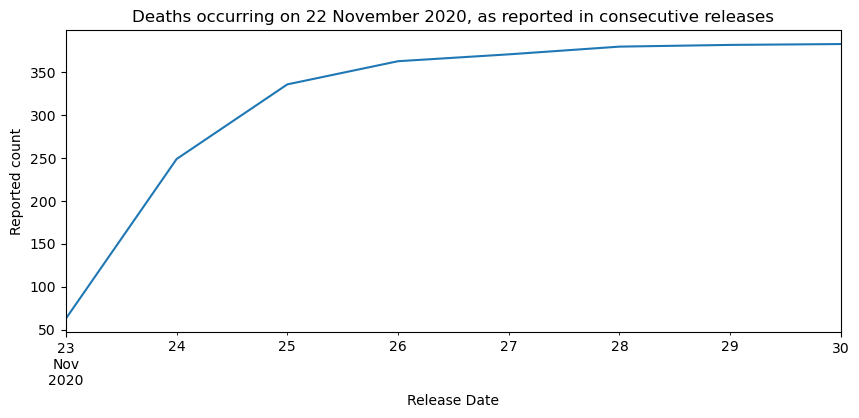

In [61]:
plt.figure(figsize=(10,4), dpi=100)
df['2020-11-22'].dropna().plot(title='Deaths occurring on 22 November 2020, as reported in consecutive releases', 
                               ylabel='Reported count')

plt.savefig('countvrelease_nov-22.png', format='png', bbox_inches='tight')
plt.show()

This shape of curve is similar for each of the dates in Aug through Nov.

Next I went back to the full dataset and plotted the difference between the minimum and maximum values across all releases for each date of death:

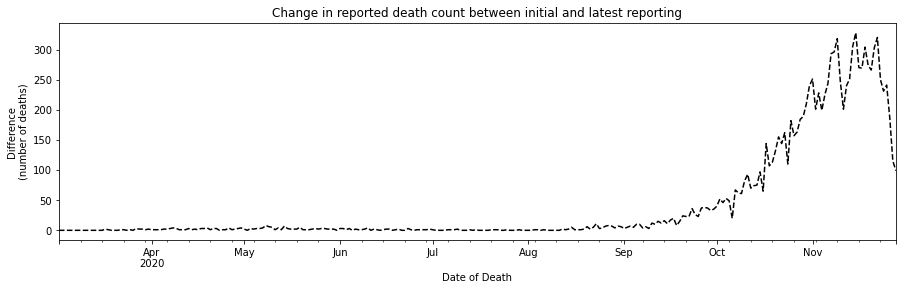

In [23]:
maxmin_diff = (df.max()-df.min())
maxmin_diff.plot(figsize=(15,4), 
                 style='k--', 
                 title='Change in reported death count between initial and latest reporting', 
                 ylabel='Difference\n(number of deaths)', 
                 xlabel='Date of Death')

plt.show()

Taking the dataset as a whole, the average difference between lowest and highest reporting is 41. The median difference is only 2. The death counts for some days did not change between releases. The maximum discrepancy is 328 for 2020-11-15 – the count for this date was initially reported as 48

In [24]:
maxmin_diff.describe().round(1)

count    272.0
mean      41.1
std       82.3
min        0.0
25%        1.0
50%        2.0
75%       23.0
max      328.0
dtype: float64

In [25]:
maxmin_diff.nlargest(10)

2020-11-15    328
2020-11-22    320
2020-11-09    318
2020-11-14    305
2020-11-18    304
2020-11-21    303
2020-11-08    296
2020-11-07    293
2020-11-19    274
2020-11-16    270
dtype: int64

In this dataset, there's close to zero discrepancy between smallest and largest reported values for at least March to August. Following that, the discrepancy grows to a maximum above 300 during the ongoing second wave in November.

It stands to reason that the max-min difference would be greater during a period of rapid growth. It's reasonable to assume that's what we're seeing here in November. A larger number of deaths each day leads to a greater day-to-day increase with each update, and ultimately a final figure far greater than initially reported.

___TL;DR: The lack of difference between Mar-June is an artefact of the dataset.___ The reason we don't see the same peak during the first lockdown is because the first release in this dataset was published 23 August, by which time the reported daily death count for Mar-Jun has already settled to something approaching the true value. Releases earlier than 23 August were not available through the PHE API, but if I could obtain that data it would be interesting to perform the same max-min analysis for Mar-Apr-May. I suspect that the discrepancy in the first wave would be even greater than that for the second.

**In the remainder of this notebook I'm going to focus on the period of August through November**.

In [26]:
columns = df.columns

startd = '2020-08-23' #<-- this felt quicker / more readable than constructing pd.Timestamp objects for indexing
endd = '2020-11-28'

starti = columns.get_loc(startd)
endi = columns.get_loc(endd) + 1

selection = df[columns[starti:endi]]

In [27]:
selection.describe().round(0).astype(int).transpose().sample(30).sort_index()

,count,mean,std,min,25%,50%,75%,max
2020-08-23,98,12,1,2,13,13,13,13
2020-08-24,97,5,0,3,5,5,5,6
2020-08-30,91,6,1,0,5,6,6,7
2020-08-31,90,6,1,1,6,6,7,7
2020-09-06,84,8,1,0,8,8,8,10
2020-09-07,83,13,1,10,13,13,13,14
2020-09-08,82,9,1,3,9,9,9,9
2020-09-09,81,9,1,6,9,9,9,9
2020-09-10,81,11,2,0,12,12,12,12
2020-09-14,76,16,2,1,17,17,17,17


To get some idea of spread, the cell below plots the standard deviation for each date of death and lists the 30 dates of death with the largest S.D.

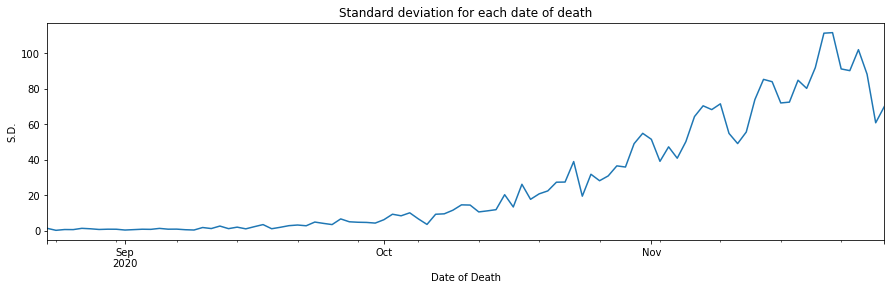

2020-11-22    111.5
2020-11-21    111.2
2020-11-25    102.0
2020-11-20     91.8
2020-11-23     91.1
2020-11-24     90.2
2020-11-26     88.2
2020-11-14     85.3
2020-11-18     84.8
2020-11-15     83.9
2020-11-19     80.2
2020-11-13     73.9
2020-11-17     72.5
2020-11-16     72.0
2020-11-09     71.5
2020-11-07     70.4
2020-11-28     70.0
2020-11-08     68.3
2020-11-06     64.3
2020-11-27     60.9
2020-11-12     55.7
2020-10-31     54.9
2020-11-10     54.9
2020-11-01     51.6
2020-11-05     50.2
2020-11-11     49.2
2020-10-30     49.1
2020-11-03     47.3
2020-11-04     40.9
2020-11-02     39.2
Name: std, dtype: float64

In [28]:
stds = selection.describe().loc['std']

stds.plot(figsize=(15,4), title='Standard deviation for each date of death', ylabel='S.D.', xlabel='Date of Death')
plt.show()
stds.round(1).nlargest(30)

Most of the top 30 dates of death with the largest spread fall in November. The largest standard deviations occur on consecutive days; the 21 and 22. I don't think this tells us anything new. When the death rate outstrips the speed of reporting, the data's always going to be a bit more spread out.

Still, pandas makes it really easy to do this, so nothing gained but nothing lost either.


## Charting the discrepancy

With the above exploration complete, it is relatively straightforward to express what was found graphically.

Creating the difference plot for this selection:

In [29]:
minimums = selection.min()
maximums = selection.max()
differences = maximums - minimums

In [30]:
differences.describe().round(1)

count     98.0
mean     111.6
std      105.3
min        3.0
25%       15.2
50%       68.5
75%      201.0
max      328.0
dtype: float64

In [31]:
differences.nlargest(10)

2020-11-15    328
2020-11-22    320
2020-11-09    318
2020-11-14    305
2020-11-18    304
2020-11-21    303
2020-11-08    296
2020-11-07    293
2020-11-19    274
2020-11-16    270
dtype: int64

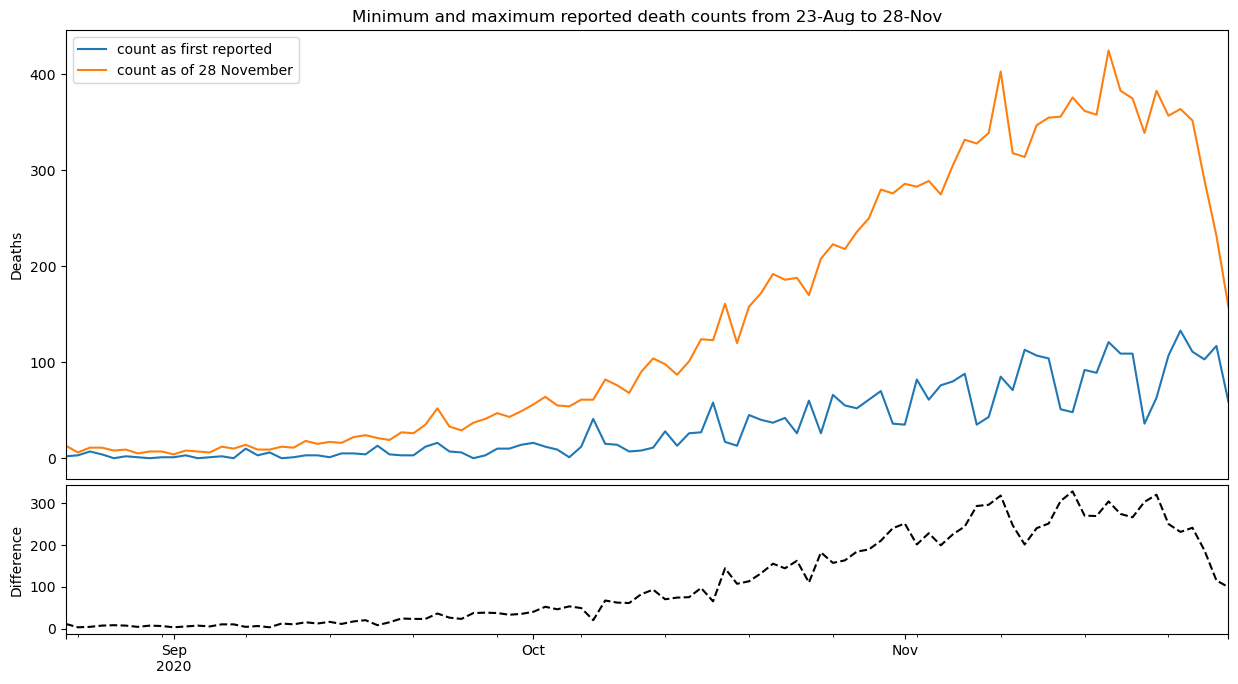

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8), dpi=100, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.02)

minimums.plot(label='count as first reported', legend=True, ax=ax1)
maximums.plot(label='count as of 28 November', legend=True, ax=ax1)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title(f'Minimum and maximum reported death counts from 23-Aug to 28-Nov')
ax1.set_ylabel('Deaths')

differences.plot(label='difference', legend= False, ax=ax2, style='k--')
ax2.set_ylabel('Difference')

plt.savefig('aug_nov_diffs.png', format='png', bbox_inches='tight')
plt.show()

Theres some clear periodicity going on here, so I resampled the data as weekly aggregates. This created a smoother curve:

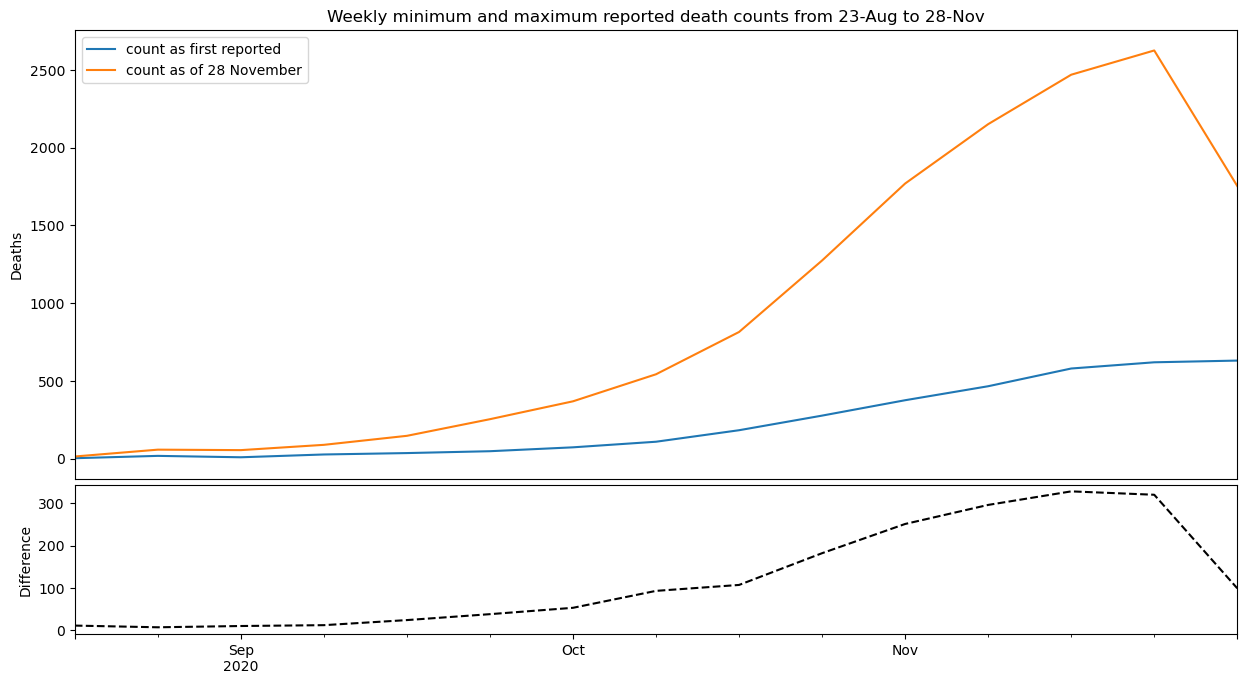

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8), dpi=100, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.02)

minimums.resample('W').sum().plot(label='count as first reported', legend=True, ax=ax1)
maximums.resample('W').sum().plot(label='count as of 28 November', legend=True, ax=ax1)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title(f'Weekly minimum and maximum reported death counts from 23-Aug to 28-Nov')
ax1.set_ylabel('Deaths')

differences.plot(label='difference', legend= False, ax=ax2, style='k--')
ax2.set_ylabel('Difference')

plt.show()

## How quickly do the counts approach their 'true' value?

Just from eyeballing the charts, it looks like the numbers for the last 3-7 days are likely to increase significantly over the next few releases. My next task is to get a more quantitative sense of how long that might take and how much those counts might increase, based off the past data. 

In [34]:
# First drop the last few days to remove data that is most incomplete

selection = selection.drop(selection.columns[-5:], axis=1)

Which is the more reliable approximation of the final count: the first quartile, median, or mean?

In [35]:
(((selection.quantile(0.25)).astype(int)/(selection.max()))*100).describe().round(2)

count     93.00
mean      92.17
std        8.56
min       50.00
25%       89.16
50%       94.55
75%       98.18
max      100.00
dtype: float64

In [36]:
(((selection.quantile(0.5)).astype(int)/(selection.max()))*100).describe().round(2)

count     93.00
mean      96.29
std        6.37
min       50.00
25%       94.74
50%       98.31
75%      100.00
max      100.00
dtype: float64

In [37]:
((selection.mean()/(selection.max()))*100).describe().round(2)

count    93.00
mean     91.54
std       6.05
min      54.49
25%      89.23
50%      93.34
75%      95.00
max      98.76
dtype: float64

To me, it looks like the median provides the best approximation. For 75% of the data, it represents at least 95% of the final count, with a S.D. spread of 6(%).

Proceeding with the median as my approximator, I first identified the date of the first release reporting a death count at or above the median for each date of death.

*On reflection, it may have been better to use the mean. For dates of death more than a few weeks in the past, the count reported in a lot of the releases will just be repeats of the final figure. This introduces a skew that has less of an effect on the mean than the median.*

In [38]:
release_date_of_median = selection.apply(lambda col : col[col >= col.median()].first_valid_index())
release_date_of_median

2020-08-23   2020-09-12
2020-08-24   2020-08-26
2020-08-25   2020-09-04
2020-08-26   2020-08-31
2020-08-27   2020-09-11
                ...    
2020-11-19   2020-11-25
2020-11-20   2020-11-26
2020-11-21   2020-11-26
2020-11-22   2020-11-27
2020-11-23   2020-11-27
Length: 93, dtype: datetime64[ns]

Taking advantage of the fact that the index is the date of death, I can easily calculate how long it takes for updates to reach the median for each date of death.

In [39]:
delay_to_median = release_date_of_median - release_date_of_median.index

In [40]:
delay_to_median.describe()

count                            93
mean     11 days 15:13:32.903225806
std       4 days 19:05:17.729165989
min                 2 days 00:00:00
25%                 8 days 00:00:00
50%                12 days 00:00:00
75%                14 days 00:00:00
max                26 days 00:00:00
dtype: object

Therefore, using the median as an approximation of the final value, it looks like it takes 11-12 days on average for the reported count of deaths to be within 5-10% of the final value (minimum 2 days, maximum 26 days).

Which date took the longest to reach this approximation?

In [41]:
delay_to_median.idxmax()

Timestamp('2020-10-01 00:00:00')

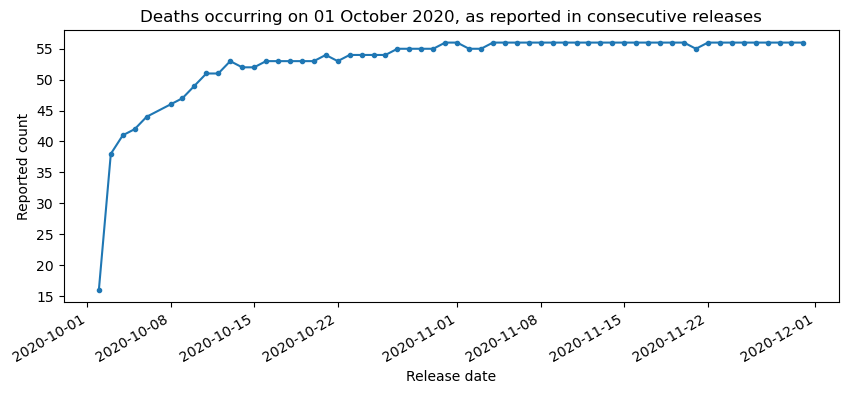

In [42]:
plt.figure(figsize=(10,4), dpi=100)
selection['2020-10-01'].dropna().plot(
    title='Deaths occurring on 01 October 2020, as reported in consecutive releases', 
    ylabel='Reported count', 
    xlabel='Release date', 
    marker='o', markersize=3)

plt.show()

Updated reports appear to trickle in much more slowly in the 10-14 days after the second release.

Something interesting to note here is the apparent fluctuation, where some releases report a lower death count than the previous release. I assume this is the result of some error correction process, correcting overestimates and miscounts, but I don't know for sure.

## Accuracy of count 'x' days after first report

The UK government considers the most recent 5 days of data to be incomplete. Based on the data from 23 Aug to 23 Nov, how closely do the reported counts after 5 days approximate the final figures?

In [43]:
d_later = 5
time_lag = pd.Timedelta(days=d_later)
drop_label = pd.Timestamp('2020-10-07') - time_lag #<-- dealing with the pesky missing release from 07-10-2020

lag_df = selection[selection.columns[:-d_later]].drop(drop_label, axis=1)
lag_lambda = lambda col : col.loc[col.name + time_lag]

lag_counts = lag_df.apply(lag_lambda)

counts_max = lag_df.max()

((lag_counts / counts_max)*100).describe().round(1)

count     87.0
mean      83.9
std        9.4
min       40.0
25%       80.5
50%       85.7
75%       89.7
max      100.0
dtype: float64

On average, the reported counts account for about 84% of the final counts; at the extreme minimum accounting for 40%.

In [44]:
((lag_counts / counts_max)*100).nsmallest(30)

2020-08-29    40.000000
2020-08-28    55.555556
2020-08-27    62.500000
2020-09-10    66.666667
2020-09-21    69.230769
2020-08-30    71.428571
2020-09-03    71.428571
2020-09-07    71.428571
2020-10-09    72.058824
2020-09-12    72.222222
2020-08-25    72.727273
2020-09-24    72.727273
2020-09-02    75.000000
2020-09-05    75.000000
2020-10-03    76.363636
2020-08-23    76.923077
2020-09-09    77.777778
2020-10-23    78.191489
2020-10-01    78.571429
2020-09-17    79.166667
2020-10-04    79.629630
2020-11-05    80.327869
2020-10-30    80.714286
2020-10-31    80.797101
2020-09-29    81.395349
2020-10-28    81.779661
2020-09-11    81.818182
2020-09-14    82.352941
2020-11-06    82.530120
2020-10-19    82.911392
dtype: float64

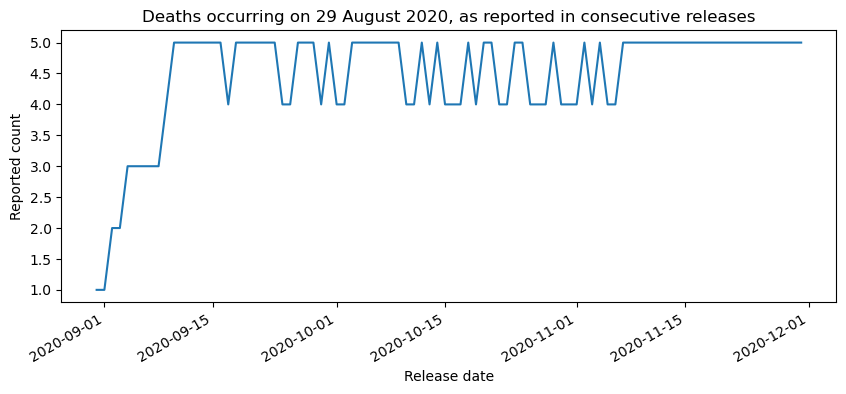

In [45]:
plt.figure(figsize=(10,4), dpi=100)
selection['2020-08-29'].dropna().plot(
    title='Deaths occurring on 29 August 2020, as reported in consecutive releases', 
    ylabel='Reported count', 
    xlabel='Release date')

plt.show()

The fluctuation from one release to the next is even more pronounced for this date of death (and the others nearby). This is partly explained by the low overall numbers, but it does at least appear to be a more frequent oscillation, and the count isn't going up which suggests it's not an overestimation error. Curious…

To visualise how accuracy increases as more time elapses, I can plot the following graph:

In [51]:
lag_mma = []

for d_later in range(1,21):
    
    time_lag = pd.Timedelta(days=d_later)
    drop_label = pd.Timestamp('2020-10-07') - time_lag #<-- dealing with the pesky missing release from 07-10-2020

    lag_df = selection[selection.columns[:-d_later]].drop(drop_label, axis=1)
    lag_lambda = lambda col : col.loc[col.name + time_lag]

    lag_counts = lag_df.apply(lag_lambda)

    counts_max = lag_df.max()
    
    lag_min = ((lag_counts / counts_max)*100).quantile(0.25)
    lag_max = ((lag_counts / counts_max)*100).quantile(0.75)
    lag_med = ((lag_counts / counts_max)*100).median()
    lag_av = ((lag_counts / counts_max)*100).mean()
    
    lag_mma.append([d_later,lag_min,lag_med,lag_max,lag_av])

In [52]:
all_lag = pd.DataFrame(lag_mma).set_index(0)

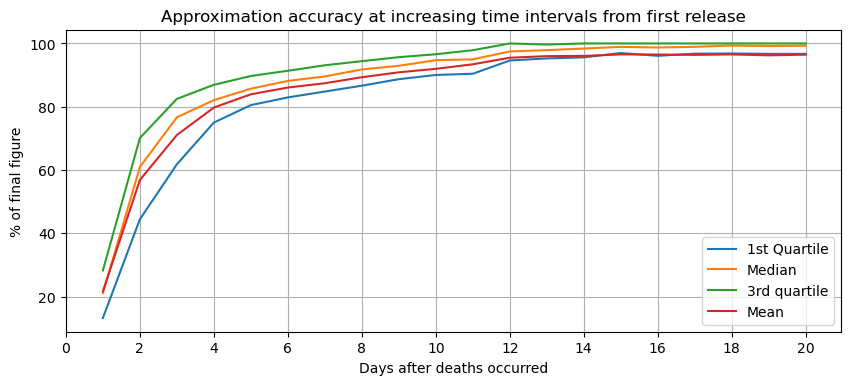

In [53]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_lag)
plt.xticks(range(0,21,2), range(0,21,2))
plt.title('Approximation accuracy at increasing time intervals from first release')
plt.xlabel('Days after deaths occurred')
plt.ylabel('% of final figure')
plt.legend(['1st Quartile', 'Median','3rd quartile', 'Mean'])
plt.grid()
plt.show()

# Alternative visualisations

In [54]:
import seaborn as sns

### Meteors
A way of visualising all of the data at once

In [55]:
strp_plot_df = selection.melt(ignore_index=False).dropna().set_axis(['Date of death','Reported deaths'], axis=1)
strp_plot_df['Date of death'] = strp_plot_df['Date of death'].copy().apply(pd.Timestamp)
strp_plot_df['Delay'] = (strp_plot_df.index - strp_plot_df['Date of death']).apply(lambda d : d.days).apply(lambda d : '7+' if d >= 7 else str(d))

strp_plot_df.info()
strp_plot_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4881 entries, 2020-08-24 to 2020-11-30
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date of death    4881 non-null   datetime64[ns]
 1   Reported deaths  4881 non-null   object        
 2   Delay            4881 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 152.5+ KB


,Date of death,Reported deaths,Delay
Release Date,,,
2020-08-24,2020-08-23,2,1
2020-08-25,2020-08-23,8,2
2020-08-26,2020-08-23,10,3
2020-08-27,2020-08-23,10,4
2020-08-28,2020-08-23,10,5


In [56]:
strp_plot_df.sort_values('Delay')

,Date of death,Reported deaths,Delay
Release Date,,,
2020-09-26,2020-09-26,0,0
2020-09-10,2020-09-10,0,0
2020-10-04,2020-10-04,1,0
2020-09-14,2020-09-13,3,1
2020-10-20,2020-10-19,45,1
...,...,...,...
2020-11-16,2020-09-10,12,7+
2020-11-15,2020-09-10,12,7+
2020-11-14,2020-09-10,12,7+


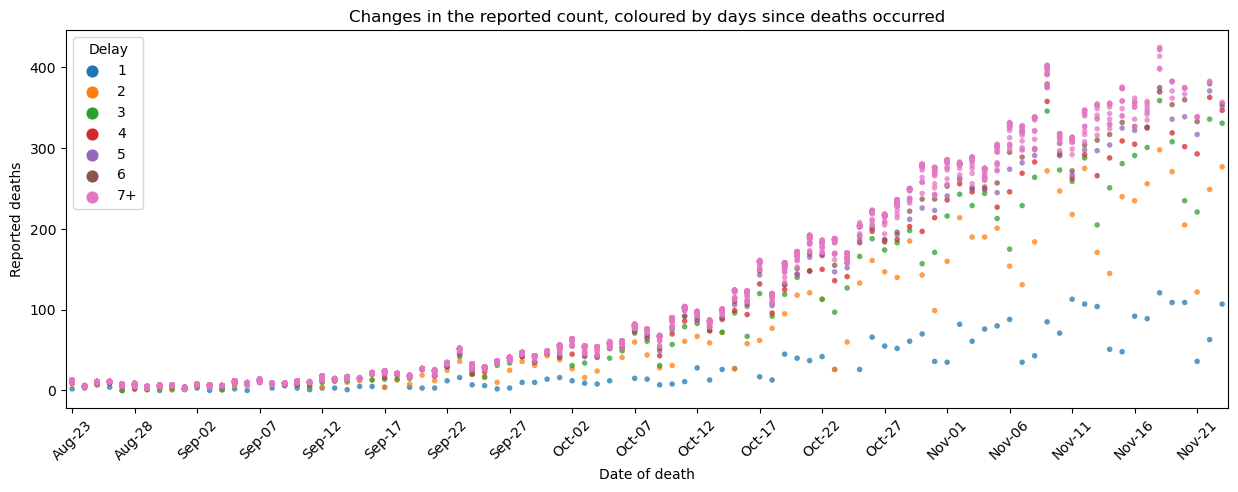

In [57]:
plt.figure(dpi=100, figsize=(15,5))
sns.stripplot(x='Date of death', y='Reported deaths', data=strp_plot_df, 
              hue='Delay', 
              hue_order=[str(n) for n in range(1,7)] + ['7+'], 
              size=4,
              lw=2,
              jitter=0,
              alpha=0.75)

xtick, xlabel = plt.xticks()
plt.xticks(xtick[::5], [pd.Timestamp(t.get_text()).strftime('%b-%d') for t in xlabel[::5]],rotation=45)

plt.title('Changes in the reported count, coloured by days since deaths occurred')

plt.savefig('meteors.png', format='png', bbox_inches='tight')
plt.show()

- Each **dot** represents the count for one date of death as reported in **a single release.**<br/>
- Each **vertical line of dots** represents all counts for one date of death as reported in **consecutive releases.**<br/>
- Points form coloured strata to preserve a sense of how the reported counts increase over time.

Without specifying hue, seaborn applies a colour gradient along the x-axis:

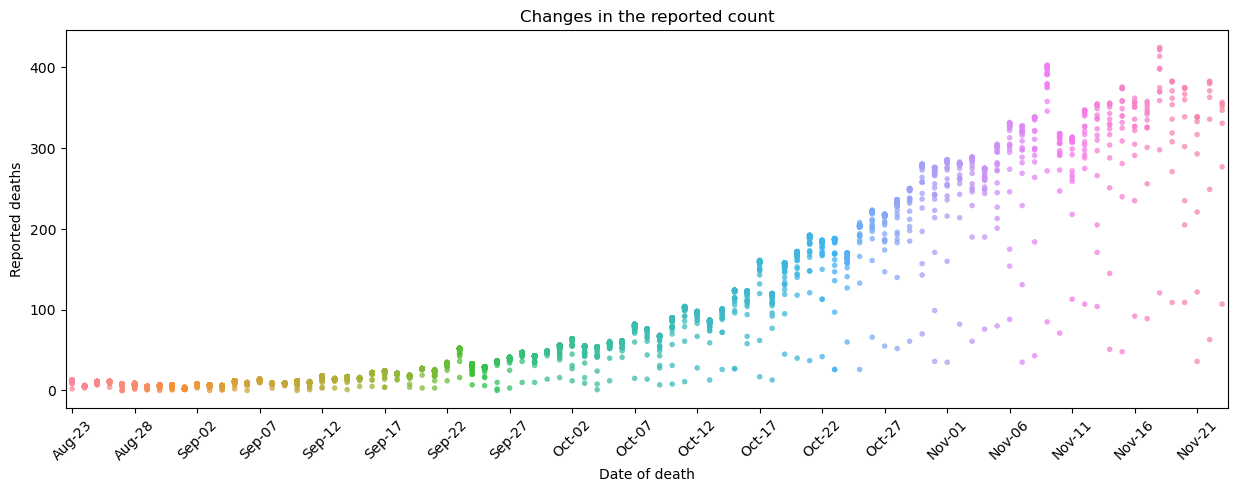

In [58]:
plt.figure(dpi=100, figsize=(15,5))
sns.stripplot(x='Date of death', y='Reported deaths', data=strp_plot_df, 
              size=4,
              lw=2,
              jitter=0,
              alpha=0.75)

xtick, xlabel = plt.xticks()
plt.xticks(xtick[::5], [pd.Timestamp(t.get_text()).strftime('%b-%d') for t in xlabel[::5]],rotation=45)

plt.title('Changes in the reported count')

plt.savefig('meteors_nohue.png', format='png', bbox_inches='tight')
plt.show()

### Dropped straws

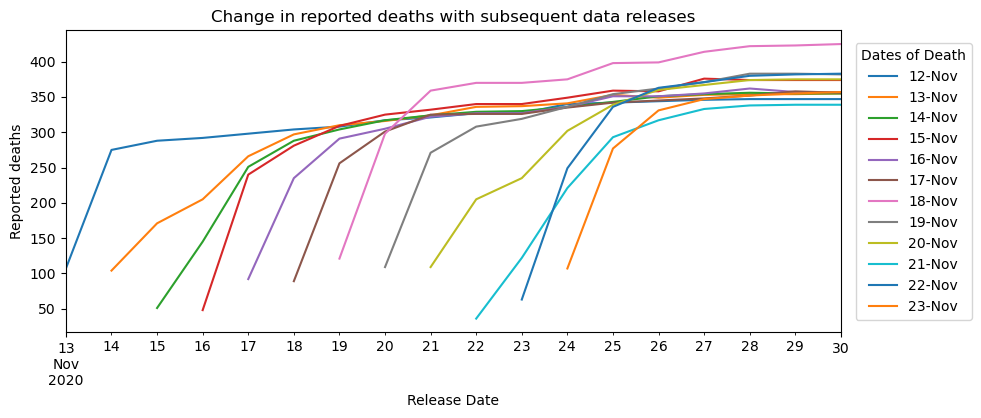

In [59]:
plt.figure(figsize=(10,4), dpi=100)

for col in selection.columns[-12:]:
    selection[col].dropna().plot()
    
plt.ylabel('Reported deaths')
plt.title('Change in reported deaths with subsequent data releases')

plt.legend([d.strftime('%d-%b') for d in selection.columns[-12:]], title='Dates of Death', loc='center left', bbox_to_anchor=(1.01,0.5))

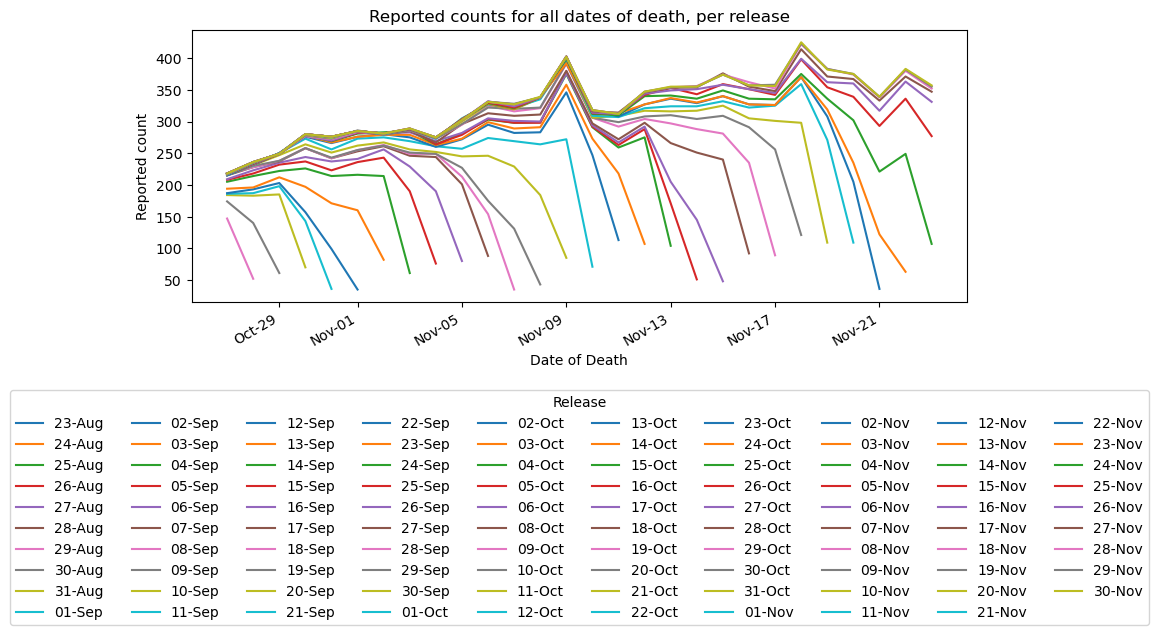

In [60]:
plt.figure(figsize=(10,4),dpi=100)

for r in selection.index:
    selection.loc[r].dropna()[65:].plot(label=str(r))
    
plt.title('Reported counts for all dates of death, per release')
plt.ylabel('Reported count')
plt.xlabel('Date of Death')

ticks, labels = plt.xticks()
labels = ['Oct-29', 'Nov-01', 'Nov-05', 'Nov-09', 'Nov-13', 'Nov-17', 'Nov-21']
plt.xticks(ticks, labels)

plt.legend([d.strftime('%d-%b') for d in selection.index], 
           title='Release', 
           loc='upper center', 
           bbox_to_anchor=(0.5,-0.3), 
           ncol=10)
plt.show()

## Ideas for further work
- Create an interactive dashboard allowing users to investigate the relationship between delay since first reporting and accuracy
- Create a machine learning model to predict what the final death count will be at time = 0